# "Scraping" Notícias

In [ ]:
#Instalar bibliotecas necessárias 
!pip install pdfplumber
!pip install xlsxwriter

In [ ]:
# Importar as bibliotecas
import pandas as pd
import os
import pdfplumber
import  xlsxwriter

In [ ]:
path = '/content/textos/' # Criar pasta para armazenar os textos
files = os.listdir(path) # Listar os arquivos

In [ ]:
# Leitura dos arquivos pdf
data = []

for f in files:
  try:
    with pdfplumber.open(path+f) as pdf:
      for i in range(len(pdf.pages)):
        page = pdf.pages[i]
        data.append({
          'arquivo': f,
          'corpo': page.extract_text()
        })
  except:
    pass

df = pd.DataFrame(data)
df

In [ ]:
# Remover \n dos textos
df = df.replace('\n',' ', regex=True)
# Exportar para excel
df.to_excel('emtempo.xlsx', encoding='utf8', engine='xlsxwriter')

# Mineração de texto

In [ ]:
# Carregar a base, já revisada manualmente
df = pd.read_excel('/content/emtempo.xlsx')
df.head(3)

,arquivo,corpo,titulo
0,adolescente-e-morto-a-pauladas-na-frente-da-na...,"Um adolescente, identificado como Lucas Souza ...",Adolescente é morto a pauladas na frente da na...
1,homem-e-agredido-pela-populacao-apos-furtar-lo...,"Manaus – Um homem, identificado pela polícia c...",Homem é agredido pela população após furtar lo...
2,reportagem-flagra-suspeito-de-roubo-sendo-espa...,Manaus – Um homem foi agredido suspeito de ass...,Reportagem ﬂagra suspeito de roubo sendo espan...


In [ ]:
# Importar bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import re

In [ ]:
# Baixar módulos
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Lista de stopwords customizada
stopWords = []

stopwords_pretext = open('/content/stopwords-portugues.txt', 'r')

with stopwords_pretext as f:
    stopwords_pretext = f.read().splitlines()

stopWords = stopwords_pretext

In [ ]:
# Unir lista customizada com as palavras da NLTK
stopNLTK = stopwords.words('portuguese')
stopWords += stopNLTK

### Funções

In [ ]:
# Função para remover elementos de html
def parser(text):
    return re.sub('<[^<]+?>', '', str(text))

# Função para limpar os textos do título e do subtítulo
def limparTitulos(df):
  replacer = {'\n':' ',"[\[].*?[\]]": "",'[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’""′‘\\\]':" ", ' +': ' '}
  df = df.replace(replacer, regex=True).apply(lambda x: x.strip()).apply(lambda x: " ".join(x.lower() for x in x.split()))
  df = df.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8', errors='ignore')
  df = df.apply(lambda x: " ".join(x for x in x.split() if x not in stopWords))
  return df

# Função para limpar o texto das matérias
def limparMateria(df):
  replacer = {'\n':' ','[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’""′‘\\\]':" ", ' +': ' '}
  df = df.replace(replacer, regex=True).apply(lambda x: x.strip()).apply(lambda x: " ".join(x.lower() for x in x.split()))
  df = df.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8', errors='ignore')
  df = df.apply(lambda x: " ".join(x for x in x.split() if x not in stopWords))
  return df

# Função para tokenizar os textos
def tokenizar(df):
  df = df.apply(word_tokenize,language='portuguese') 
  return df  

# Função para contar o número de palavras por texto
def contarPalavras(df):
  lists =  df

  words = []
  for wordList in lists:
    words += wordList
  FreqDist(words)

  # Elencar os x termos mais frequentes
  fdist = FreqDist(words)
  
  # Transformar em df
  termos = pd.DataFrame(list(fdist.items()), columns = ["Termos", "Frequência"]).sort_values(by=['Frequência'], ascending=False)
  
  return termos

# Função para gerar as nuvens de palavras
def gerarNuvem(df):
  df = df.set_index('Termos').to_dict()['Frequência']
  wc = WordCloud(width=800, height=400, max_words=200, background_color = 'white', contour_width=3, contour_color='steelblue').generate_from_frequencies(df)

  plt.figure(figsize=(10, 10))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.show()
  return plt.show()

### Pré-processamento

In [ ]:
df['materiaLimpa'] = df.corpo.apply(parser)
df['tituloLimpo'] = df.titulo.apply(parser)

df['tituloLimpo'] = limparTitulos(df['tituloLimpo'])
df['cleanmateriaLimpa'] = limparMateria(df['materiaLimpa'])

## Tokenização e frequências

In [ ]:
df['tokenizeTitulo'] = tokenizar(df['tituloLimpo'])
df['tokenizeMateria'] = tokenizar(df['cleanmateriaLimpa'])

In [ ]:
frequenciaTitulo = contarPalavras(df['tokenizeTitulo'])
frequenciaTitulo.head(10) 

,Termos,Frequência
7,homem,68
8,agredido,51
14,suspeito,42
17,espancado,35
19,video,34
5,zona,31
23,assalto,26
31,morte,24
2,pauladas,24
1,morto,23


In [ ]:
frequenciaMateria = contarPalavras(df['tokenizeMateria'])
frequenciaMateria.head(10)

,Termos,Frequência
15,policia,368
95,homem,309
29,zona,278
23,bairro,236
104,suspeito,232
47,vitima,231
16,crime,175
73,local,160
164,agredido,151
19,rua,147


## Nuvem de palavras

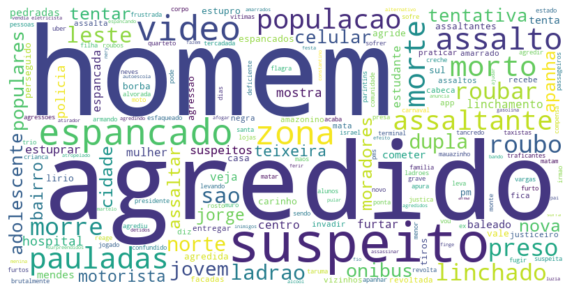

In [ ]:
gerarNuvem(frequenciaTitulo)

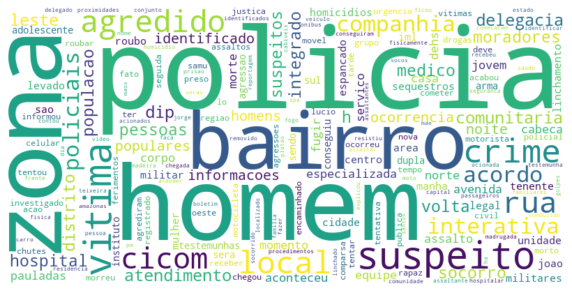

In [ ]:
gerarNuvem(frequenciaMateria)